In [1]:
import csv, math
from math import exp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# g: list of G(0), ..., G(t)
def pid_controller(g, target, day_flag):
    # Parameters
    Kp=0.285
    if day_flag:
        Ti=450
        Td=90
        target = 4.95
    else:
        Ti=150
        Td=60
        target = 6.05
    
    errors = g - target
    
    # Calculate u(t) using PID based on errors
    ut = Kp * errors[-1] + (Kp / Ti) * sum(errors) + (Kp / Td) * (errors[-1] - errors[-2])
    # Remove negative u(t)
    if ut < 0:
        ut=0
#     else:
#         ut = 0.06 * ut
    
    return ut

In [3]:
# Human Glucose - Insulin System Model by Bergman 1981
# A simple 3 equation model.

# States = [Plasma Glucose(G), 
#           Plasma Insulin Remote Compartment(X), 
#           Plasma Insulin(I)]

# From the paper Estimation-based Model Predictive Control of Blood Glucose in Type I Diabetics: A Simulation Study
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=924729&tag=1

def bergman_minmod(x, U, D):
    
    # Get the last G(t), X(t) and I(t)
    G=x[-1, 0]
    X=x[-1, 1]
    I=x[-1, 2]
    
    # Parameters
    Gb = 4.5
    Ib = 15
    
    # For T1D, in some papers P1 = 0 to T1D
    P1 = 0
    P2 = 0.025
    P3 = 0.000013
    VI = 12
    n = 0.0926
    
    # Minimal Model
    Gdt = -P1 * G - X * (G + Gb) + D
    Xdt = -P2 * X + P3 * I
    Idt = -n * (Ib + I) + U / VI
    
    dx_dt = [Gdt, Xdt, Idt]
    return dx_dt

In [4]:
# Create meal profile to simulate one afternoon of diabetes patient
def meal_profile(t):
    if t < 100:
        m = 0
    # Lunch
    elif t >= 100 and t < 9000:
        m = 2 * exp(-0.001 * (t-100))
    # Snack
    elif t >= 9000 and t < 16000:
        m = 1 * exp(-0.001 * (t-9000))
    # Dinner
    elif t >= 16000 and t < 21600:
        m = 2 * exp(-0.001 * (t-16000))
    else:
        m = 0

    return m

In [5]:
############ Simulation on the original bergman minimal model ############

In [6]:
# Simulate one afternoon of a patient's life
# 6*60*60 = 21600 seconds
tend = 21600
tspan = [i for i in range(tend)]

# Set up initial conditions
x0 = x1 = [4.5, 15, 15]
x = np.array([x0, x1])

# Set point of blood glucose level
g_target = 6

# Meal profiles
m = []
for t in tspan:
    m.append(0)
#     m.append(meal_profile(t))

# Simulation
for t in tspan:
    dx_dt = bergman_minmod(x, pid_controller(x[:, 0], g_target, 1), m[t])
    
    # x(t) = x(t-1) + dx/dt
    xt = x[-1] + dx_dt
    
    # Append xt to x
    x = np.vstack([x, xt])

# Display the list of G(t), X(t) and I(t)
x

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


array([[   4.5     ,   15.      ,   15.      ],
       [   4.5     ,   15.      ,   15.      ],
       [-130.5     ,   14.625195,   12.222   ],
       ...,
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan]])

In [7]:
# Ignore the initial conditions
x = x[2:]
# Select G(t), X(t) and I(t)
G=x[:, 0]
X=x[:, 1]
I=x[:, 2]

# Set the thresholds
glucose_high = 8.3
glucose_low = 4.4

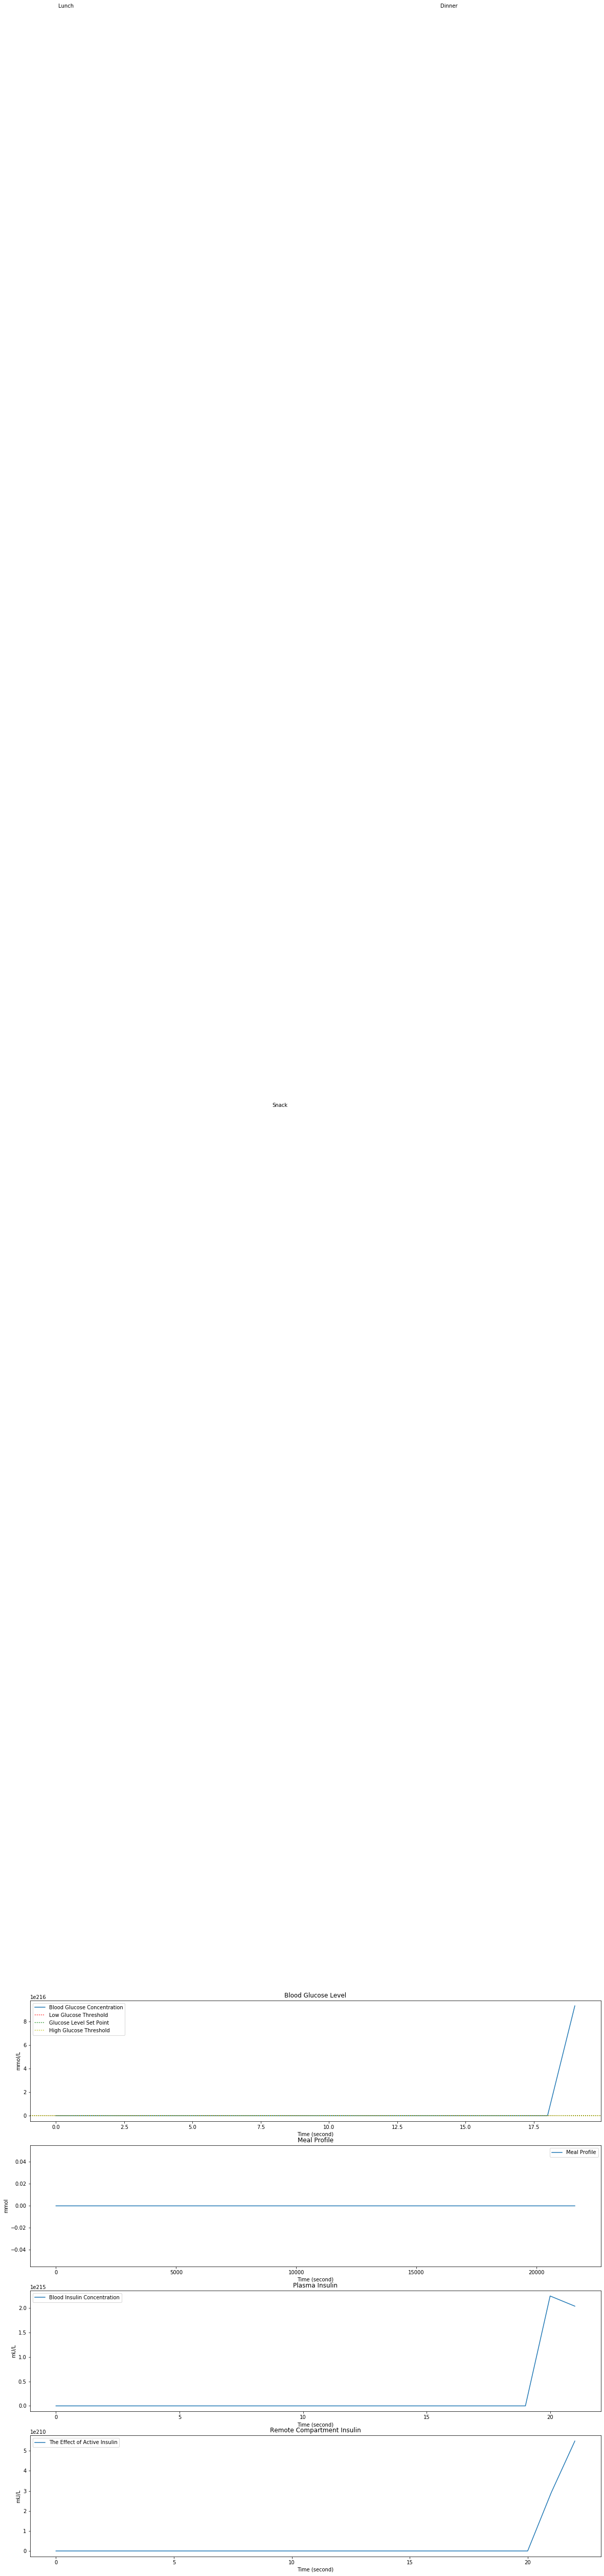

In [8]:
# Visulisation
plt.figure(figsize=(20, 20))
plt.subplot(4,1,1)
plt.plot(tspan,G, label='Blood Glucose Concentration')
plt.axhline(y = glucose_low, color = 'r', linestyle = ':', label='Low Glucose Threshold')
plt.axhline(y = g_target, color = 'g', linestyle = ':', label='Glucose Level Set Point')
plt.axhline(y = glucose_high, color = 'y', linestyle = ':', label='High Glucose Threshold')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mmol/L')
plt.title('Blood Glucose Level')

plt.subplot(4,1,2)
plt.text(100, 2, 'Lunch')
plt.text(9000, 1, 'Snack')
plt.text(16000, 2, 'Dinner')
plt.plot(tspan, m, label='Meal Profile')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mmol')
plt.title('Meal Profile')

plt.subplot(4,1,3)
plt.plot(tspan, I, label='Blood Insulin Concentration')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mU/L')
plt.title('Plasma Insulin')

plt.subplot(4,1,4)
plt.plot(tspan, X, label='The Effect of Active Insulin')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mU/L')
plt.title('Remote Compartment Insulin')

plt.show()

In [9]:
############ Simulation on the modified bergman minimal model ############

In [10]:
# # Simulate one afternoon of a patient's life
# # Parameters
# pars = [0.0025, 0.0163, 9.8*10**(-7), 0.008, 0.007, 122, 15.2]

# # # 6*60*60 = 21600 seconds
# # tend = 21600
# # tspan = [i for i in range(tend)]

# # Set up initial conditions
# x0 = x1 = [4.5, 15, 15]
# x_modified = np.array([x0, x1])

# # Set point of blood glucose level
# g_target = 6

# # # Meal profiles
# # m = []
# # for t in tspan:
# #     m.append(meal_profile(t))

# # Simulation
# for t in tspan:
#     dx_dt = bergman_minmod_modified(x_modified, pid_controller_modified(x_modified[:, 0], g_target), m[t], pars)
    
#     # x(t) = x(t-1) + dx/dt
#     xt = x_modified[-1] + dx_dt
    
#     # Append xt to x
#     x_modified = np.vstack([x_modified, xt])

# # Display the list of G(t), X(t) and I(t)
# x_modified

In [11]:
# # Ignore the initial conditions
# x_modified = x_modified[2:]
# # Select G(t), X(t) and I(t)
# G_modified = x_modified[:, 0]
# X_modified = x_modified[:, 1]
# I_modified = x_modified[:, 2]

# # Visulisation
# plt.figure(figsize=(20, 20))
# plt.subplot(4,1,1)
# plt.plot(tspan,G_modified, label='Blood Glucose Concentration')
# plt.axhline(y = glucose_low, color = 'r', linestyle = ':', label='Low Glucose Threshold')
# plt.axhline(y = g_target, color = 'g', linestyle = ':', label='Glucose Level Set Point')
# plt.axhline(y = glucose_high, color = 'y', linestyle = ':', label='High Glucose Threshold')
# plt.legend()
# plt.xlabel('Time (second)')
# plt.ylabel('mmol/L')
# plt.title('Blood Glucose Level')

# plt.subplot(4,1,2)
# plt.text(100, 2, 'Lunch')
# plt.text(9000, 1, 'Snack')
# plt.text(16000, 2, 'Dinner')
# plt.plot(tspan, m, label='Meal Profile')
# plt.legend()
# plt.xlabel('Time (second)')
# plt.ylabel('mmol')
# plt.title('Meal Profile')

# plt.subplot(4,1,3)
# plt.plot(tspan, I_modified, label='Blood Insulin Concentration')
# plt.legend()
# plt.xlabel('Time (second)')
# plt.ylabel('mU/L')
# plt.title('Plasma Insulin')

# plt.subplot(4,1,4)
# plt.plot(tspan, X_modified, label='The Effect of Active Insulin')
# plt.legend()
# plt.xlabel('Time (second)')
# plt.ylabel('mU/L')
# plt.title('Remote Compartment Insulin')

# plt.show()